In [ ]:
!pip install --quiet hdmedians

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
from lib.utils import *
from copy import deepcopy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

def get_repo_name(i):
    """Get id from lookup... then get name from bigquery table? """
    pass
    
def predict_ai(model, pos, X):
    """ pos is the positive class vectors, X is the entire dataset """    
    model = deepcopy(model)
    model.fit(pos)
    preds = model.predict(X)
    return np.argwhere(preds == 1), model

def print_random(pos, amt=30):
    print('Printing {}/{} positive documents'.format(amt, len(pos)))
    np.random.shuffle(pos)
    for p in pos[0:30]: 
        print(get_sentence(p[0]))

In [8]:
size = int(5472100/2)
embeddings = get_embeddings('./ss/ss_repo_embeds.txt', size)

In [3]:
with open('old_nips_repos.txt', 'r') as f: 
    repos = [l.strip() for i,l in enumerate(f)]
        
write_ai_readmes(repos, 'prepared-readmes/old-ai-readmes.txt')

REPO 404: HellooYing/ShuangChuang
REPO 404: ethereon/netscope


In [5]:
# USE STARSPACE TO WRITE VECTORS FROM THESE TEXTS
# bash scripts/embed-ai-readmes.sh prepared-readmes/old-ai-readmes.txt ss/old-ai-vectors.txt

In [31]:
vecs = np.array(get_ss_embed('ss/old-ai-vectors.txt'))

## Visualize Embedded Space

In [32]:
from scipy.spatial.distance import euclidean, cosine
from hdmedians import geomedian, medoid

def distance_from(arr, v):
    dist = lambda d: euclidean(d, v)
    return np.apply_along_axis(lambda d: euclidean(d, v), 1, arr)

def distances_from_med(vecs, embeddings, med = None):
    """ Generate distance of each embedding from medoid of vecs """
    med = med or np.asarray(medoid(vecs.T))
    return distance_from(embeddings, med)

def pick_local_sample(distances, embedding, sample_size, thresh):
    s = embeddings[distances < thresh]
    idx = np.random.choice(s.shape[0], sample_size, replace=False)
    sample = s[idx]
    return sample

In [33]:
distances = distances_from_med(vecs, embeddings)

## One-Class SVM

In [134]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(kernel='rbf', nu = .5, gamma = 1/1000)

In [150]:
from sklearn.manifold import MDS, Isomap, LocallyLinearEmbedding, TSNE

def project(embeddings, vecs):
    mds = MDS()
    X = np.concatenate([vecs, embeddings])
    manifold = mds.fit_transform(X)
    labels = np.concatenate([np.ones(vecs.shape[0]), np.zeros(embeddings.shape[0])])
    df = pd.DataFrame(manifold, columns = ['x', 'y']).assign(source = pd.Series(labels))
    return df
    
def plot_predictions(model, df):
    X = df[['x', 'y']].values
    vecs = X[df.source == 1]
    pos,mod = predict_ai(model, vecs, X)
    
    # Add support vectors
    df['support_vector'] = False
    df.loc[mod.support_ ,'support_vector'] = True
    
    # Add labels for source
    lab = np.array(['Papers' if i == 1 else 'Random' for i in df.source])
    lab[pos[:,0]] = 'Classified'
    df['label'] = lab
    sns.scatterplot(x = 'x', y = 'y', style='source', hue = 'label', data = df, markers = ['P', ','], palette="bright")

In [38]:
sample = pick_local_sample(distances, embeddings, sample_size=500, thresh=1.2)

In [118]:
df = project(sample, vecs)

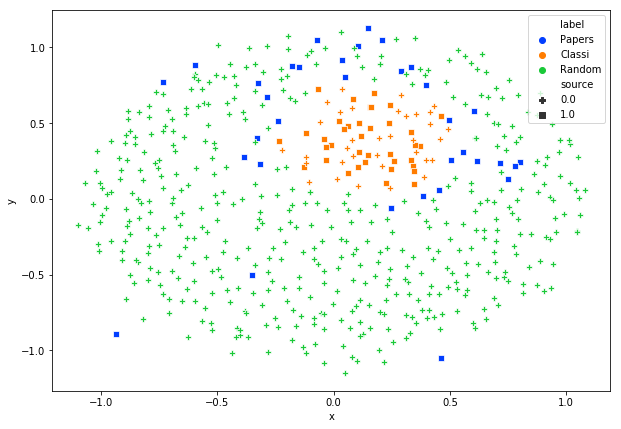

In [151]:
plot_predictions(svm, df)

In [40]:
pos,_ = predict_ai(svm, vecs, embeddings)
len(vecs), len(pos)

(73, 5981)

In [ ]:
print_random(pos)

## Evaluation

In [ ]:
svm.decision_function(sample)